In [1]:
import sys
import pandas as pd
import pickle
from AMLpp.transformers import *
from AMLpp.conveyor import *
from AMLpp.architect import *

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\analytic6\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\analytic6\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_excel('test.xlsx')

In [5]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline

import sys
sys.path.insert(0, "C:\\Users\\analytic6\\Desktop\\Work Space Analitic 6 (Asir)\\AMLpp\\_AssemblyAmlpp\\AMLpp")
sys.path.insert(0,'C:\\Users\\analytic6\\Desktop\\Work Space Analitic 6 (Asir)')
sys.path.insert(0,'C:\\Users\\User\\Desktop\\work')

from typing import List, Callable

import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from tpot import TPOTRegressor

from additional import LGBOptimizer

from datetime import datetime
import lightgbm as lgb
import pandas as pd
import warnings
import optuna
import pickle
import shap
import time

import tqdm 

##############################################################################
class Conveyor:
    """ Подобие sklearn.Pipeline, адаптированный под простоту и добавленный функционал

    Parameters
    ----------
    *block : object
        Объекты классов, что будут использоваться при обработке, и моделирование

    """

    ##############################################################################

    def __init__(self, *blocks, estimator:object  = None, **params):
        self.blocks = list(blocks)
        self.estimator = estimator
        # self.iter = 0
        warnings.filterwarnings('ignore')
        
    def __repr__(self):
        _repr = self.__class__.__name__ + "= (\n"
        indent = " " * (len(_repr) - 1)
        for block in self.blocks:
            _repr += f"{indent}{repr(block)}, \n"
        _repr += f"{indent}estimator = {repr(self.estimator)}"
        _repr += f"\n{indent} )"
        return _repr

    # def __next__(self):
    #     if self.iter < len(self.blocks):
    #         self.iter +=1 
    #         return self.block[iter]
    #     else:
    #         self.iter = 0
    #         return StopIteration

    # def __getitem__(self, key):
    #     if isinstance(key, slice):
    #         return self.__class__(self.blocks[key])
    #     else:
    #         return self.blocks[key]
    ##############################################################################

    # @lead_time
    def fit(self, X:pd.DataFrame,
                  Y:pd.DataFrame or pd.Series,
                  feature_importances:str = False):
        self._fit(X, Y)
        if feature_importances:
            self.feature_importances(X, Y, transform = False)

    # @lead_time
    def fit_transform(self, X:pd.DataFrame, Y:pd.DataFrame or pd.Series):
        return self._fit(X, Y)

    def _fit(self, X:pd.DataFrame, Y:pd.DataFrame or pd.Series):
        X_, Y_  = (X.copy(), Y.copy())

        pbar = tqdm.tqdm(self.blocks)
        for block in pbar:
            pbar.set_postfix({'transform': block.__class__.__name__})
            block.fit(X_, Y_)
            X_, Y_ = self._transform(block, X_, Y_)

        pbar.set_postfix({'transform': self.estimator.__class__.__name__})
        self.estimator.fit(X_, Y_)
        pbar.close()
        return X_, Y_
    ##############################################################################

    # @lead_time
    def transform(self,
                        X:pd.DataFrame,
                        Y:pd.DataFrame or pd.Series = pd.DataFrame()):
        X_, Y_  = (X.copy(), Y.copy())
        for block in self.blocks:
            X_, Y_ = self._transform(block, X_, Y_)
        return X_, Y_

    def _transform(self, 
                        block:Callable,
                        X:pd.DataFrame,
                        Y:pd.DataFrame or pd.Series = pd.DataFrame()):
        X = block.transform(X)
        if not Y.empty and 'target_transform' in dir(block):
            Y = block.target_transform(Y)
        return X, Y

    ##############################################################################

    # @lead_time
    def predict(self, X:pd.DataFrame):
        return self.estimator.predict(self.transform(X.copy())[0])

    ##############################################################################
    # @lead_time
    def score(self,
                X:pd.DataFrame,
                Y:pd.DataFrame or pd.Series,
                sklearn_function:List[str] = ['roc_auc_score', 'r2_score', 'accuracy_score'],
                precision_function:List[Callable] = [],
                _return:bool = False):
        """
        X:pd.DataFrame,
        Y:pd.DataFrame or pd.Series,
        sklearn_function:List[str] = ['roc_auc_score', 'r2_score', 'accuracy_score'],
        precision_function:List[Callable] = []
        """
        X_, Y_ = self.transform(X.copy(), Y.copy())
        result = self.estimator.predict(X_)
        score = ""
        for func in sklearn_function:
            try:
                exec('from sklearn.metrics import ' + func)
                score += "function - {} = {}\n".format(func, eval("{}(Y_, result)".format(func)))
            except Exception as e:
                score += "function - {} = ERROR: {}\n".format(func, e)
        for func in precision_function:
            try:
                score = "function - {} = {}\n".format(func.__name__, func(Y_, result))
            except Exception as e:
                score = "function - {} = ERROR: {}\n".format(func.__name__, e)

        if _return:
            return score, result, Y_
        else:
            print(score)
    # @lead_time
    def feature_importances(self,
                            X:pd.DataFrame,
                            Y:pd.DataFrame or pd.Series, 
                            show:str = 'all', # all, sklearn, shap
                            save:bool = True,
                            name_plot:str = "",
                            transform = True): 
                            
        if transform:
            X_, Y_ = self.transform(X.copy(), Y.copy())

        if show == 'all' or show == 'shap':
            try:
                explainer = shap.Explainer(self.estimator)
                shap_values = explainer(X_)
                shap.plots.bar(shap_values[0], show = False)
                if save:
                    name_plot = name_plot if name_plot != "" else datetime.now().strftime("%Y-%m-%d_%M")
                    plt.savefig('{}_shap.jpeg'.format(name_plot), dpi = 150,  pad_inches=0)
                plt.show()
            except Exception as e:
                print('shap plot - ERROR: ', e)

        if show == "all" or show == "sklearn":
            try:
                result = permutation_importance(self.estimator, X_, Y_, n_repeats=2, random_state=42)
                index = X_.columns if type(X_) == pd.DataFrame else X.columns
                forest_importances = pd.Series(result.importances_mean, index=index)
                fig, ax = plt.subplots(figsize=(20, 10))
                forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
                ax.set_title("Feature importances using permutation on full model")
                ax.set_ylabel("Mean accuracy decrease")
                fig.tight_layout()
                if save:
                    name_plot = name_plot if name_plot != "" else datetime.now().strftime("%Y-%m-%d_%M")
                    plt.savefig('{}_sklearn.jpeg'.format(name_plot))
                plt.show()
            except Exception as e:
                print('Sklearn plot - ERROR: ', e)
        if self.estimator.__class__.__name__ == "LGBMRegressor":
            lgb.plot_importance(self.estimator, figsize=(20, 10))
            plt.savefig('{}_lgb.jpeg'.format(name_plot))
            plt.show()
    ##############################################################################
    # @lead_time
    def fit_model(self, 
                    X:pd.DataFrame, Y:pd.DataFrame or pd.Series,
                    X_test:pd.DataFrame = None, Y_test:pd.DataFrame = None,
                    type_model:str = 'regressor',
                    export_model:str = "default",
                    compare_model:bool = True,
                    tpot_params:dict  = {"generations":5, "population_size":50, "n_jobs":-1},
                    lgb_params:dict = {"n_trials":20,  "n_jobs" :-1}, categorical_columns:List[str] = []
                    ):


        X_train, Y_train = self.fit_transform(X, Y)

        if type(X_test) != type(None) and type(Y_test) != type(None):
            X_test, Y_test = self.transform(X_test, Y_test)
        else:
            X_test, Y_test = X_train, Y_train
            
        print('start fit tpot model !!!!')
        tpot_model, result = self.fit_model_tpot(X_train, Y_train, X_test, params = tpot_params)
        tpot_score = r2_score(Y_test, result)
        print(tpot_model,"\n",f"r2_score = {tpot_score}")
        time.sleep(1)
        print('start fit lgb model !!!!')
        lgb_model, result = self.fit_model_lgb(X_train, Y_train, X_test, Y_test, 
                                                categorical_columns = categorical_columns, params = lgb_params)
        lgb_score = r2_score(Y_test, result)
        print(lgb_model,"\n",f"r2_score = {lgb_score}")

        if tpot_score > lgb_score:
            for step in tpot_model.steps[:-1]:
                self.blocks.append(step)
            self.estimator = tpot_model[-1]
            print("BEST Conveyor: TPOT")
        else:
            self.estimator = lgb_model
            print("BEST Conveyor: LGB")
            
        print(self)
        if export_model != "":
            if export_model == "default":
                export_model = "model_" + datetime.now().strftime("%Y_%m_%d_m%M")
            with open(export_model, 'wb') as save_file:
                pickle.dump(self, save_file)

    def fit_model_tpot(self, X:pd.DataFrame, Y:pd.DataFrame, X_test:pd.DataFrame, params:dict = {}):
        tpot = TPOTRegressor(**params, random_state=42).fit(X, Y)
        make_pipe, import_libs = tpot.export('', get_pipeline=True)
        exec(import_libs)
        model = eval(make_pipe)
        model = model if (type(model) == Pipeline) else make_pipeline(model)
        return model.fit(X, Y), model.predict(X_test) if type(X_test) == pd.DataFrame else False

    def fit_model_lgb(self, X:pd.DataFrame, Y:pd.DataFrame, 
                            X_test:pd.DataFrame, Y_test:pd.DataFrame, 
                            categorical_columns:List[str] = None, params:dict = {}):
        study = optuna.create_study(direction='maximize')
        study.optimize(LGBOptimizer(X, Y, X_test, Y_test, categorical_columns = categorical_columns),
                                        **params, show_progress_bar = False)
        model = LGBMRegressor(**study.best_params, random_state=42).fit(X, Y)
        result = model.predict(X_test) if type(X_test) == pd.DataFrame else False 
        return model, result

In [3]:
from experiments.exp1.user_transform import UserTransform
from sklearn.ensemble import RandomForestRegressor
import numpy as np

categorical_columns = ['organization_type_other', 'position_other', 'email', 'ceduc', 'family', 'sstate', 'cgrag', 'income_source_id',
                      'income_frequency_id', 'has_prior_employment', 'empoyees_count_id', 'organization_branch_id', 'organization_type_id', 'position_id',
                      'employment_type_id', 'has_movables', 'has_immovables', 'fact_addr_owner_type_id', 'fact_addr_region_id', 'fact_addr_same', 'addr_owner_type_id',
                      'addr_region_id', 'education_id', 'children_count_id', 'marital_status_id', 'gender_id', 
                      'country_det','city_det', 'region_det', 'isp', 'browser', 'system', 'brand'
                      ]

model = Conveyor (
                  UserTransform(),
                  Word2Vectorization(columns=['purpose_other'], epochs = 100),
                  CategoricalEncoder(columns=categorical_columns),
                  ImputerIterative(),
                  estimator =  LGBMRegressor(cat_smooth=23, colsample_bytree=0.85, learning_rate=0.005,
              max_depth=10, min_child_samples=17, num_leaves=237,
              random_state=42, reg_alpha=0.0014249285905021153,
              reg_lambda=0.007253299932166387, subsample=0.7) 
                  )

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(df, df, test_size = 0.1, random_state=42)

In [ ]:
model.fit_model(X_train, Y_train, categorical_columns = categorical_columns, tpot_params = {"generations":1, "population_size":5, "n_jobs":-1})

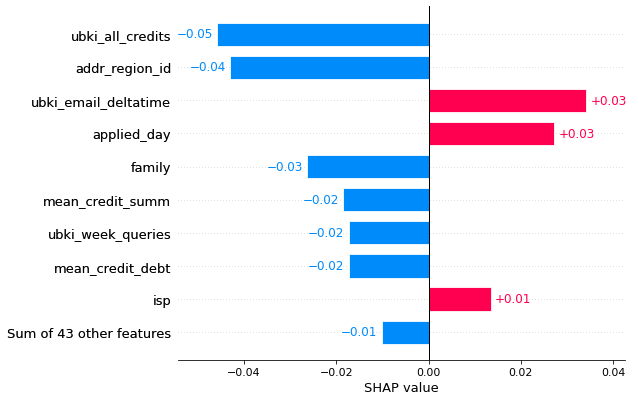

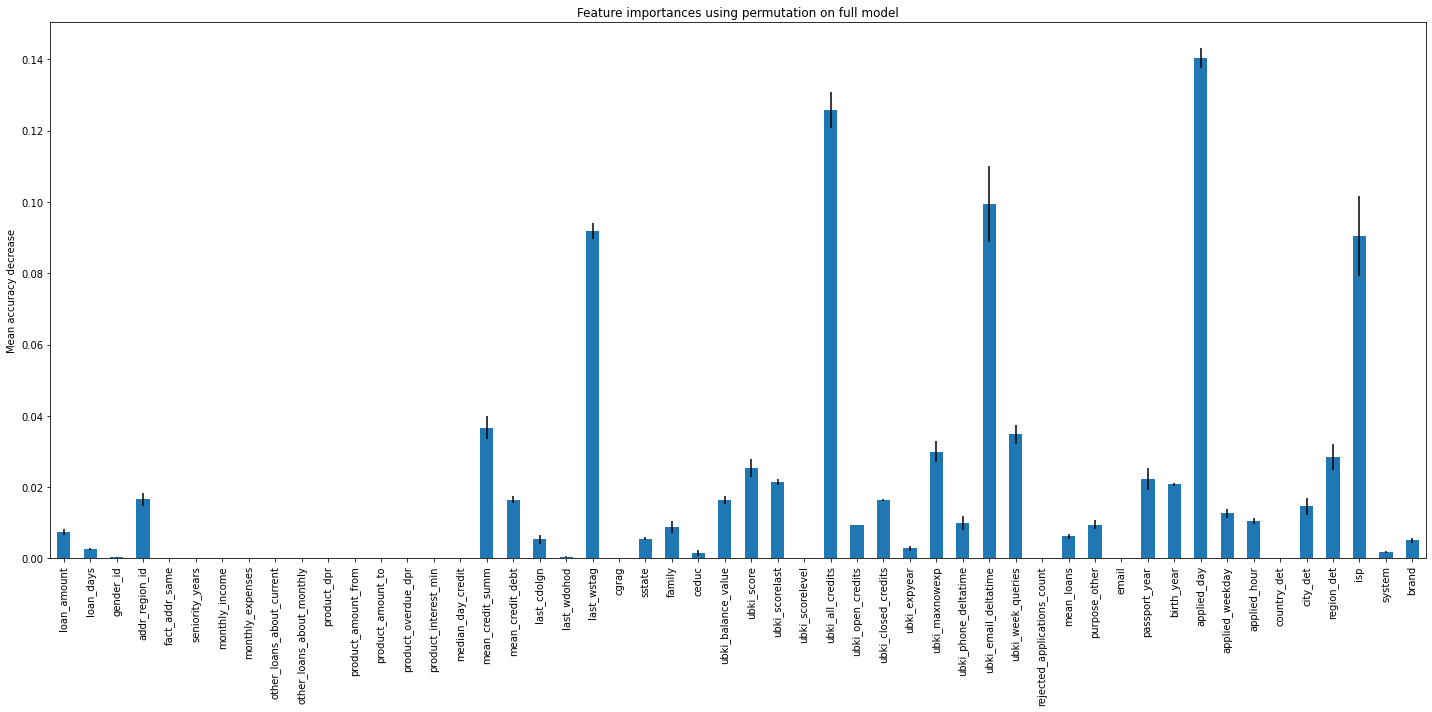

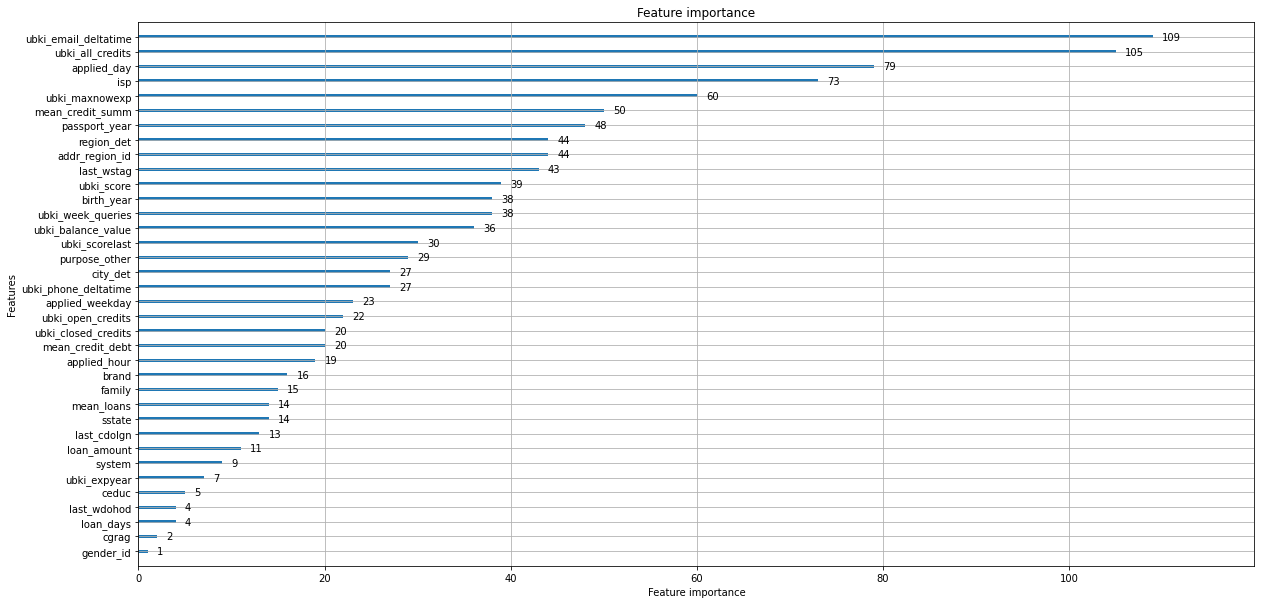

In [6]:
model.feature_importances(df, df)

In [ ]:
model.fit(df, df)

100%|██████████| 4/4 [00:01<00:00,  3.80it/s, transform=ImputerIterative]


In [179]:
model.fit(df, df)

100%|██████████| 4/4 [00:01<00:00,  3.18it/s, transform=ImputerIterative]


In [180]:
experiment = Experimenter("exp2")

In [181]:
description = \
"""
Иморт user_transform из __main__
Расширенная модель для новых пользователей, использует только статус 5 и 6.
Расширения подразумевает исользование user_agent, detection.
"""
testset_name = 'testset_2_5k_y2021_m6_new'
X_test_features = ['backend_application_id', 'overdue_days','status_id']
experiment.create_experiment(model, description, 'test', df, df, testset_name, X_test_features = X_test_features, feature_importances = False)


************************************************************
testset = testset_2_5k_y2021_m6_new
function - roc_auc_score = 1.0
function - r2_score = 0.8138249923644658
function - accuracy_score = ERROR: Classification metrics can't handle a mix of binary and continuous targets



In [56]:
experiment.make_experiment(X_test, y_test, testset_name, X_test_features = X_test_features)

NameError: name 'X_test' is not defined